# Лабораторная работа 6: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html)

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [ ]:
!pip install cvxopt

In [ ]:
import numpy as np
from cvxopt import solvers, matrix
p = matrix(np.array([[2, 0], [0,8.]]), tc="d")
q = matrix(np.array([-8, -16.]), tc="d")
G = matrix(np.array([[1, 1], [1, 0], [-1, 0], [0, -1]]), tc="d")
h = matrix(np.array([5, 3, 0, 0.]), tc="d")
solvers.options['show_progress'] = False
sol = solvers.qp(p,q,G,h)

In [ ]:
np.array(sol["x"]), np.array(sol["x"]).dtype


(array([[2.99999983],
        [1.99869093]]),
 dtype('float64'))

Активные ограничения: x_1 ≤ 3  и x_1 + x_2 ≤ 5

Неактивные: x_1 ≥ 0  и x_2 ≥ 0



## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [ ]:
d = 3
N = 5
y = np.array([-1,1,1,1,-1])
X = np.random.randint(1,100, size = (N,d))
G = np.block([[-y[:,None] * X, -y[:,None], -np.eye(N)],
             [np.zeros((N,d+1)), -np.eye(N)]])
G = matrix(G)
G

<10x9 matrix, tc='d'>

In [ ]:
y[:,None]

array([[-1],
       [ 1],
       [ 1],
       [ 1],
       [-1]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_classification

solvers.options['show_progress'] = False

линейно-разделимые
C=  0.01  опорные векторы:  36
C=    10  опорные векторы:   3
C=  1000  опорные векторы:   3


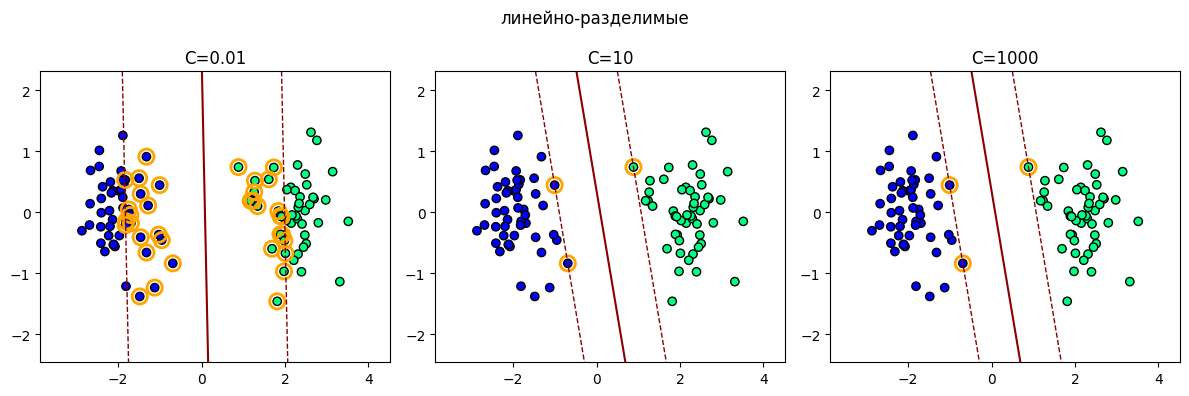

не линейно
C=  0.01  опорные векторы: 200
C=    10  опорные векторы: 200
C=  1000  опорные векторы: 200


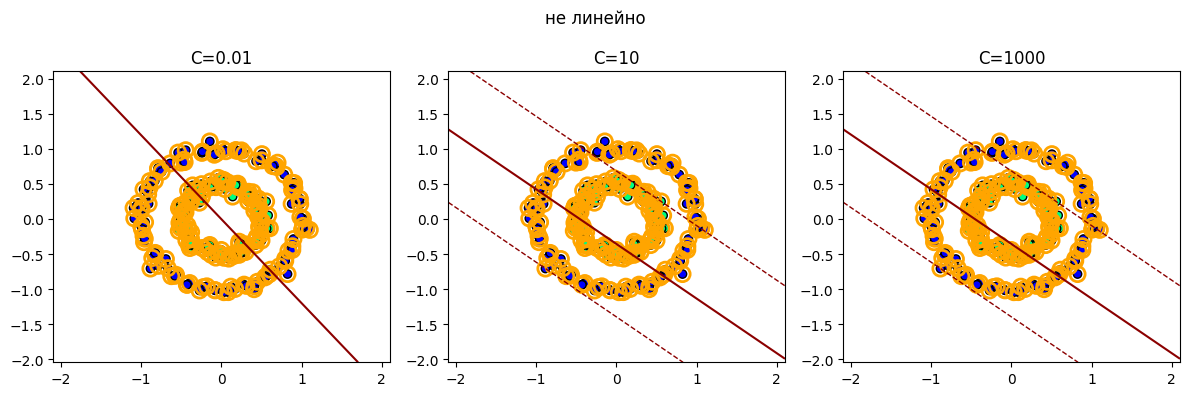

плохо разделимые
C=  0.01  опорные векторы:  84
C=    10  опорные векторы:  36
C=  1000  опорные векторы:  35


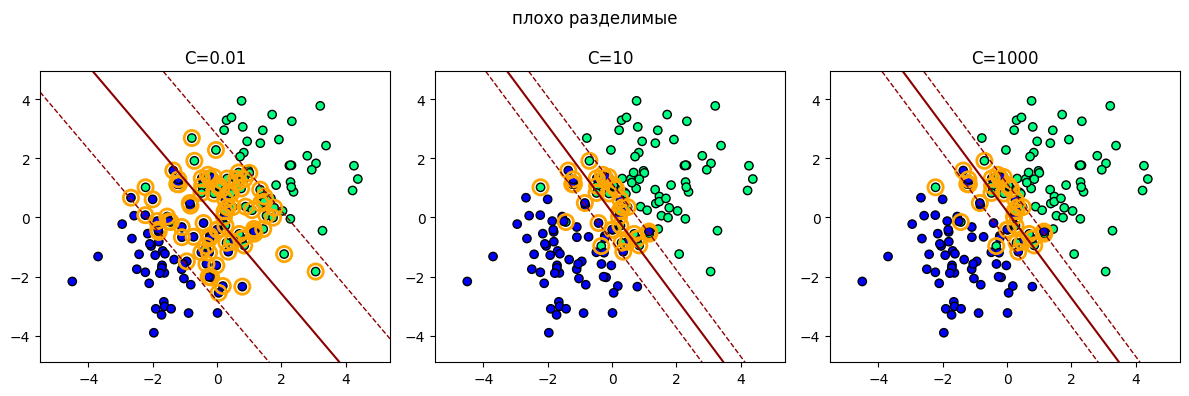

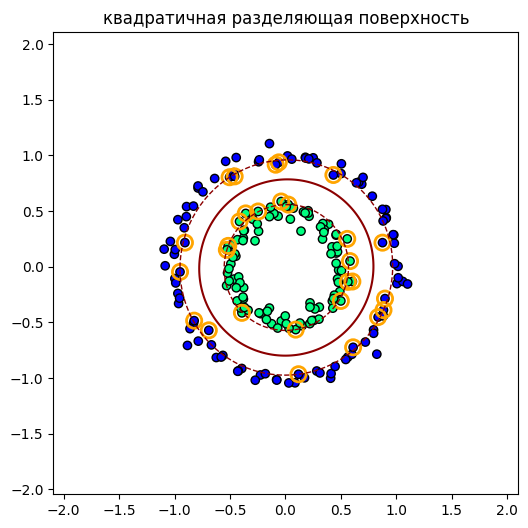

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

solvers.options['show_progress'] = False

# Вспомогательная функция для преобразования numpy массива в формат cvxopt
def _to_cvxopt_matrix(A, dtype='d'):
    A = np.asarray(A, dtype=float)
    return matrix(A)

# Реализация линейного SVM как класс, совместимый со sklearn
class LinearSVM(BaseEstimator):
    def __init__(self, C=1.0, transform=None):
        self.C = float(C)
        self.transform = transform

    def _apply_transform(self, X):
        if self.transform is None:
            return X
        else:
            return self.transform(X)

    # Обучение модели
    def fit(self, X, y):
        X = np.asarray(X, dtype=float)  # Преобразование данных в массив numpy
        y = np.asarray(y, dtype=float).flatten()  # Вектор меток
        # Проверка, что метки равны -1 или 1
        assert set(np.unique(y)).issubset({-1.0, 1.0})

        X = self._apply_transform(X)
        N, d = X.shape  # Количество образцов и признаков

        n_vars = d + 1 + N  # Общее число переменных для QP
        P = np.zeros((n_vars, n_vars))
        P[:d, :d] = np.eye(d)  # Матрица для квадратичной части (w)
        q = np.hstack([np.zeros(d + 1), self.C * np.ones(N)])  # Вектор линейных коэффициентов

        # Построение ограничений для неотрицательности slack переменных
        G1 = np.zeros((N, n_vars))
        for i in range(N):
            G1[i, :d] = -y[i] * X[i]  # Условие для w
            G1[i, d] = -y[i]  # Условие для b
            G1[i, d + 1 + i] = -1.0  # Условие для slack переменной xi
        h1 = -np.ones(N)  # Левая часть ограничений

        # Ограничения на slack переменные (xi >= 0)
        G2 = np.zeros((N, n_vars))
        G2[:, d + 1:] = -np.eye(N)
        h2 = np.zeros(N)

        # Объединение всех ограничений
        G = np.vstack([G1, G2])
        h = np.hstack([h1, h2])

        # Преобразование в формат cvxopt
        P_c = _to_cvxopt_matrix(P)
        q_c = _to_cvxopt_matrix(q)
        G_c = _to_cvxopt_matrix(G)
        h_c = _to_cvxopt_matrix(h)

        # Решение квадратичной оптимизации
        sol = solvers.qp(P_c, q_c, G_c, h_c)
        x = np.array(sol['x']).flatten()

        # Извлечение параметров модели
        w = x[:d].reshape(-1)
        b = float(x[d])
        xi = x[d + 1:]

        # Сохранение результатов
        self.weights_ = w
        self.bias_ = b
        self.slacks_ = xi
        self.n_features_in_ = d
        self._fit_X = X
        self._fit_y = y
        return self

    # Внутренний метод для вычисления функции решения
    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        X = self._apply_transform(X)
        return (X.dot(self.weights_) + self.bias_).flatten()

    # Предсказание классов
    def predict(self, X):
        return np.sign(self.decision_function(X))

    # Получение опорных векторов
    def support_vectors_(self, tol=1e-6):
        fvals = self._fit_X.dot(self.weights_) + self.bias_
        margins = self._fit_y * fvals
        # Маска для опорных векторов (на границе или внутри зазора)
        mask = (np.abs(margins - 1.0) <= 1e-4) | (self.slacks_ > tol)
        return self._fit_X[mask], self._fit_y[mask], mask

# Функция для расширения признаков квадратичной трансформацией
def quadratic_transform(X):
    X = np.asarray(X)
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    # Добавление квадратичных признаков и произведения
    return np.hstack([x1, x2, x1 ** 2, x1 * x2, x2 ** 2])

# Функция для визуализации границ решений и данных
def plot_decision(model, X, y, ax=None, title=None, show_support=True):
    if ax is None:
        ax = plt.gca()

    # Отображение исходных данных
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', edgecolors='k')

    # Создание сетки точек для построения границ
    xvals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    yvals = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    xx, yy = np.meshgrid(xvals, yvals)
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Вычисление значений функции решения на сетке
    zz = model.decision_function(grid).reshape(xx.shape)

    # Построение границ
    ax.contour(xx, yy, zz, levels=(0.0,), colors='darkred', linewidths=1.5)
    # Построение зазоров для опорных векторов
    ax.contour(xx, yy, zz, levels=tuple(sorted([1.0, -1.0])), colors='darkred', linestyles='--', linewidths=1.0)

    # Отображение опорных векторов
    if show_support:
        sv_X, sv_y, mask = model.support_vectors_()
        if len(sv_X) > 0:
            ax.scatter(sv_X[:, 0], sv_X[:, 1], s=120, facecolors='none', edgecolors='orange', linewidths=2)

    # Настройка границ графика
    ax.set_xlim(xvals[0], xvals[-1])
    ax.set_ylim(yvals[0], yvals[-1])
    if title is not None:
        ax.set_title(title)

# Основная функция для проведения эксперимента
def experiment():
    rng = np.random.RandomState(0)

    # Создание для линейно разделимых классов
    X1, y1 = make_blobs(n_samples=100, centers=[(-2, 0), (2, 0)], cluster_std=0.6, random_state=1)
    y1 = 2 * (y1 == 1) - 1  # Преобразование меток в -1 и 1

    # Создание для не линейных классов
    X2, y2 = make_circles(n_samples=200, factor=0.5, noise=0.05, random_state=2)
    y2 = 2 * y2 - 1

    # Создание для плохо разделимых классов
    X3, y3 = make_blobs(n_samples=150, centers=[(-1, -1), (1, 1)], cluster_std=1.2, random_state=3)
    y3 = 2 * (y3 == 1) - 1

    datasets = [
        (X1, y1, 'линейно-разделимые'),
        (X2, y2, 'не линейно'),
        (X3, y3, 'плохо разделимые')
    ]

    # Значения параметра C для экспериментов
    Cs = [0.01, 10, 1000]

    # Проход по наборам данных и параметрам C
    for X, y, name in datasets:
        print(name)
        fig, axes = plt.subplots(1, len(Cs), figsize=(4 * len(Cs), 4))
        for ax, C in zip(axes, Cs):
            model = LinearSVM(C=C)
            model.fit(X, y)
            sv_X, sv_y, mask = model.support_vectors_()
            print(f'C={C:>6}  опорные векторы: {mask.sum():3d}')
            # Визуализация границ и данных
            plot_decision(model, X, y, ax=ax, title=f'C={C}')
        plt.suptitle(name)
        plt.tight_layout()
        plt.show()

    # Обучение модели с квадратичной трансформацией признаков для не линейных данных
    model_q = LinearSVM(C=1.0, transform=quadratic_transform)
    model_q.fit(X2, y2)

    # Визуализация квадратичной разделяющей поверхности
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plot_decision(model_q, X2, y2, ax=ax, title='квадратичная разделяющая поверхность')
    plt.show()

if __name__ == '__main__':
    experiment()

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_.

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?


--------------------------------------------------
Датасет: Круги
--------------------------------------------------
Линейная: 150 опорных векторов (C=0.1)
Полином p=2: 131 опорных векторов (C=0.1)
RBF γ=0.5: 144 опорных векторов (C=0.1)

--------------------------------------------------
Датасет: Полумесяцы
--------------------------------------------------
Линейная: 74 опорных векторов (C=0.1)
Полином p=2: 62 опорных векторов (C=0.1)
RBF γ=0.5: 98 опорных векторов (C=0.1)

--------------------------------------------------
Датасет: Линейные
--------------------------------------------------
Линейная: 49 опорных векторов (C=0.1)
Полином p=2: 41 опорных векторов (C=0.1)
RBF γ=0.5: 144 опорных векторов (C=0.1)


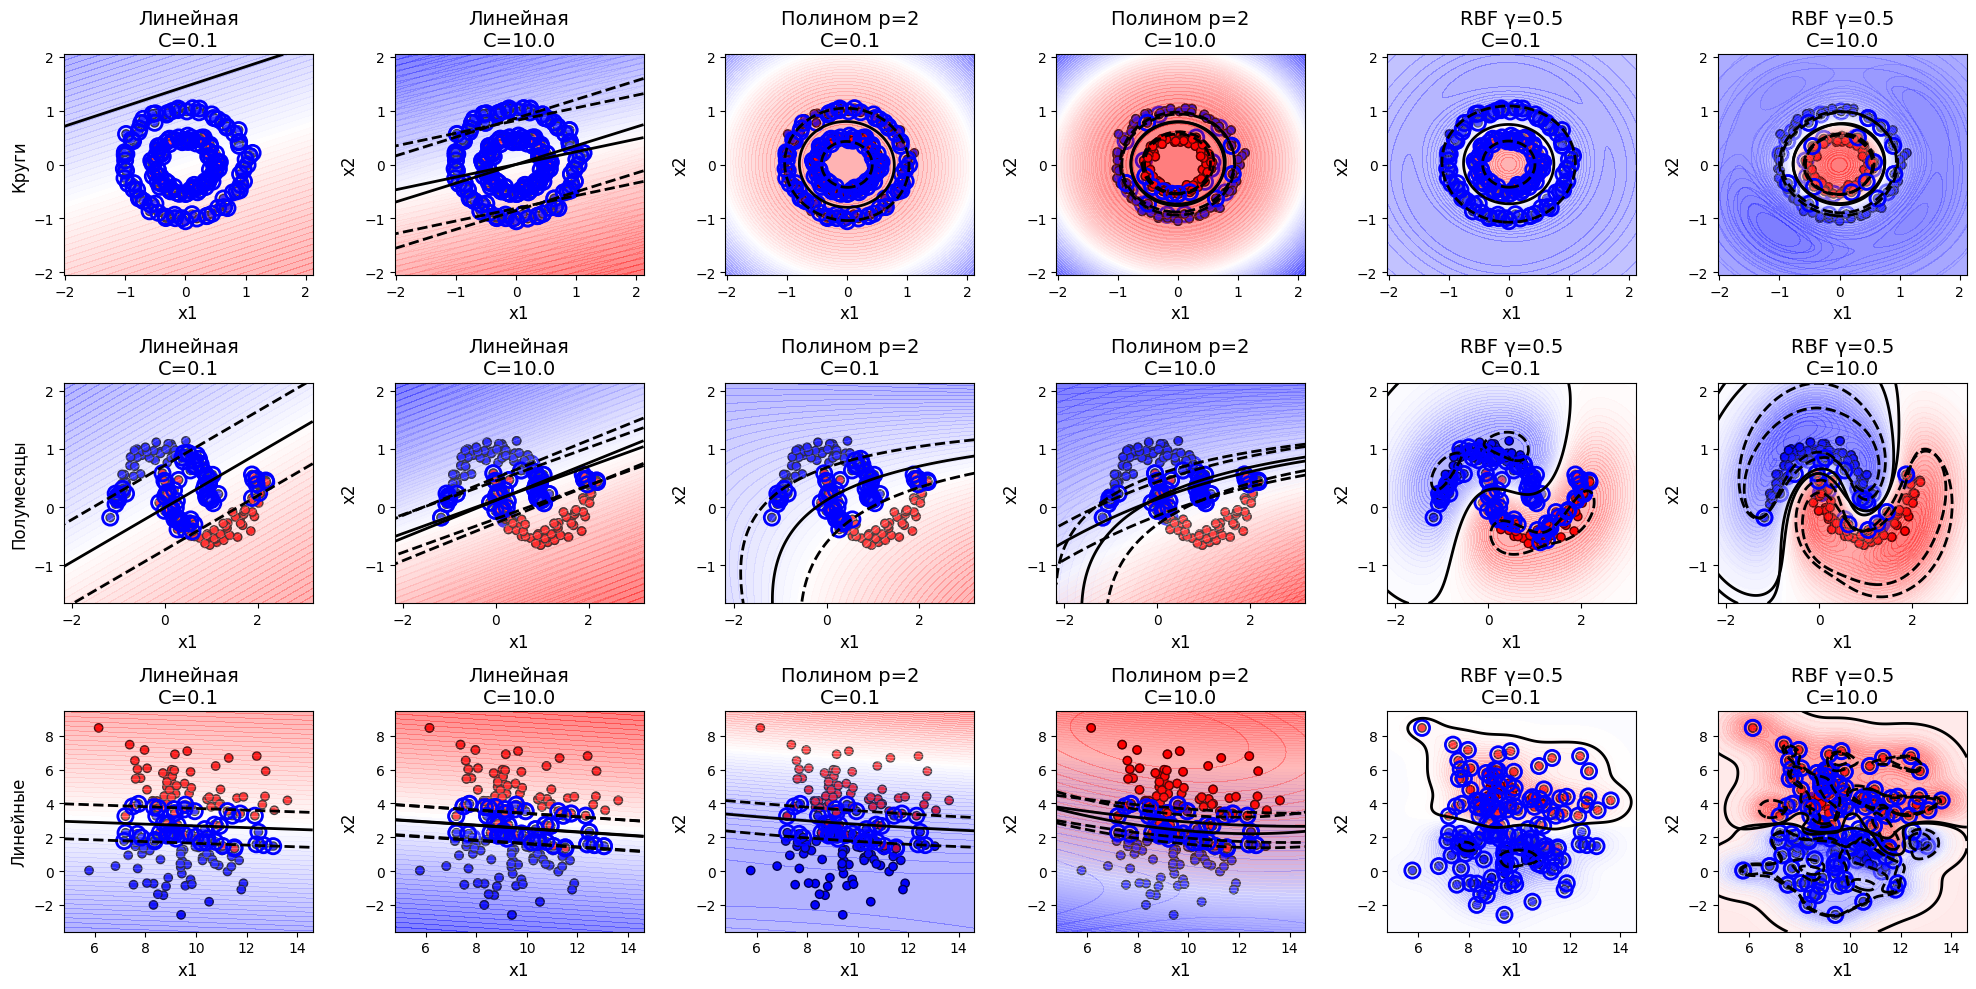



СРАВНЕНИЕ ЯДЕР НА ДАТАСЕТЕ 'КРУГИ' (C=1.0)
Линейная: 150 опорных векторов
Полином p=2: 26 опорных векторов
Полином p=3: 13 опорных векторов
RBF γ=0.5: 34 опорных векторов


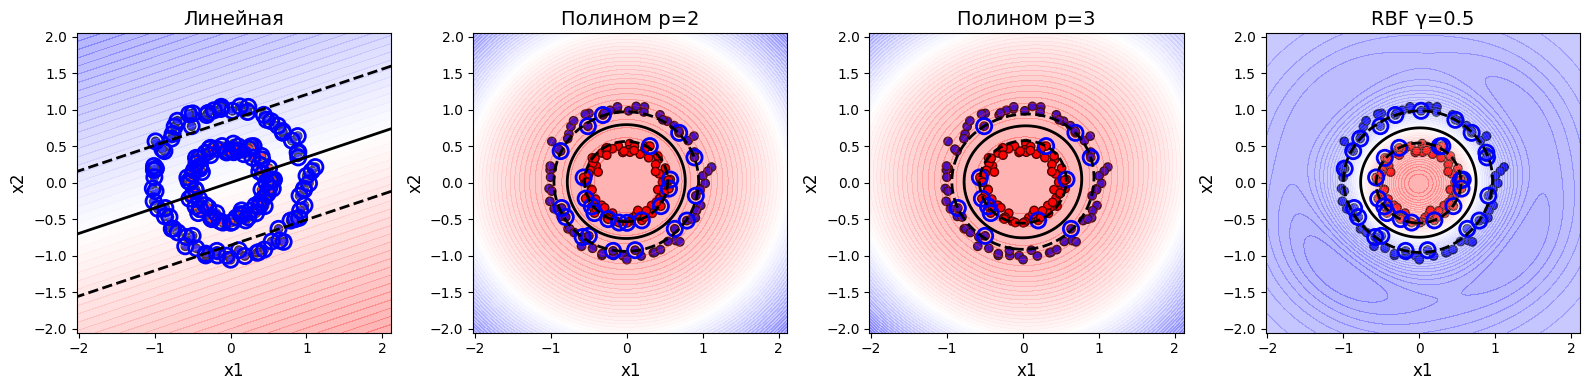

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs, make_circles, make_moons
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False

def _to_cvxopt_matrix(A):
    A = np.asarray(A, dtype=float)
    return matrix(A)

class DualSVM(BaseEstimator):
    def __init__(self, C=1.0, kernel='линейная', degree=3, gamma=None):
        self.C = float(C)
        self.kernel = kernel
        self.degree = int(degree)
        self.gamma = gamma

    def _kernel_func(self, X, Y=None):
        X = np.asarray(X)
        if Y is None:
            Y = X
        else:
            Y = np.asarray(Y)

        if self.kernel == 'линейная':
            return X.dot(Y.T)
        elif self.kernel == 'полиномиальная':
            return (X.dot(Y.T) + 1.0) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma_ = 1.0 / X.shape[1]
            else:
                self.gamma_ = float(self.gamma)
            X_norm = np.sum(X ** 2, axis=1)[:, None]
            Y_norm = np.sum(Y ** 2, axis=1)[None, :]
            K = X_norm + Y_norm - 2 * X.dot(Y.T)
            return np.exp(-0.5 / self.gamma_ * K)
        else:
            raise ValueError('ошибка: %s' % self.kernel)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).flatten()
        assert set(np.unique(y)).issubset({-1.0, 1.0})

        self.X_ = X
        self.y_ = y
        N = X.shape[0]
        K = self._kernel_func(X, X)
        Q = np.outer(y, y) * K
        P = _to_cvxopt_matrix(Q)
        q = _to_cvxopt_matrix(-np.ones(N))
        G_top = -np.eye(N)
        G_bottom = np.eye(N)
        G = _to_cvxopt_matrix(np.vstack([G_top, G_bottom]))
        h = _to_cvxopt_matrix(np.hstack([np.zeros(N), self.C * np.ones(N)]))

        A = _to_cvxopt_matrix(y.reshape(1, -1))
        b = _to_cvxopt_matrix(np.array([0.0]))

        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x']).flatten()

        self.alpha_ = alphas

        tol = 1e-6
        sv_mask = alphas > tol
        self.support_mask_ = sv_mask
        self.support_ = X[sv_mask]
        self.support_y_ = y[sv_mask]
        self.support_alpha_ = alphas[sv_mask]

        margin_sv = (alphas > tol) & (alphas < (self.C - 1e-8))
        if np.any(margin_sv):
            idxs = np.where(margin_sv)[0]
        else:
            idxs = np.where(sv_mask)[0]

        if len(idxs) == 0:
            self.intercept_ = 0.0
        else:
            bs = []
            for i in idxs:
                val = np.sum(alphas * y * K[:, i])
                bs.append(y[i] - val)
            self.intercept_ = float(np.mean(bs))

        self.n_features_in_ = X.shape[1]
        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        K = self._kernel_func(self.X_, X)
        vals = (self.alpha_ * self.y_)[:, None].T.dot(K)
        return (vals.flatten() + self.intercept_)

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def predict_proba(self, X):
        d = self.decision_function(X)
        p = 1.0 / (1.0 + np.exp(-d))
        probs = np.vstack([1 - p, p]).T
        return probs

    def support_vectors_(self):
        return self.support_, self.support_y_, self.support_alpha_, self.support_mask_

def plot_decision(model, X, y, ax=None, title=None, show_support=True):
    if ax is None:
        ax = plt.gca()

    # Визуализация точек классов
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')

    # Создаем сетку для границы
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Предсказания на сетке
    zz = model.decision_function(grid).reshape(xx.shape)

    # Цветовая заливка
    ax.contourf(xx, yy, zz, levels=np.linspace(zz.min(), zz.max(), 50), cmap='bwr', alpha=0.3)

    # Линии границ
    ax.contour(xx, yy, zz, levels=[-1, 0, 1], colors='k', linewidths=2, linestyles=['--', '-', '--'])

    # Опорные векторы
    sv_X, sv_y, sv_alpha, sv_mask = model.support_vectors_()
    if len(sv_X) > 0:
        ax.scatter(sv_X[:,0], sv_X[:,1], s=120, facecolors='none', edgecolors='b', linewidths=2)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    if title:
        ax.set_title(title, fontsize=14)
    ax.set_xlabel('x1', fontsize=12)
    ax.set_ylabel('x2', fontsize=12)

def generate_simple_datasets():
    """Генерация простых датасетов"""
    datasets = []

    # 1. Круги (нелинейно разделимый)
    X, y = make_circles(n_samples=150, noise=0.05, factor=0.5, random_state=2)
    y = 2 * y - 1
    datasets.append(("Круги", X, y))

    # 2. Полумесяцы (нелинейно разделимый)
    X, y = make_moons(n_samples=150, noise=0.1, random_state=3)
    y = 2 * y - 1
    datasets.append(("Полумесяцы", X, y))

    # 3. Линейно разделимые данные
    X, y = make_blobs(n_samples=150, centers=2, n_features=2,
                      cluster_std=1.5, random_state=4)
    y = 2 * y - 1
    datasets.append(("Линейные", X, y))

    return datasets

def experiment():
    # Получаем простые датасеты
    datasets = generate_simple_datasets()

    # Создаем фигуру для каждого датасета
    fig, axes = plt.subplots(len(datasets), 6, figsize=(20, 10))

    # Если axes одномерный, делаем его двумерным
    if axes.ndim == 1:
        axes = axes.reshape(len(datasets), -1)

    # Конфигурации для экспериментов
    configs = [
        ("Линейная", {"kernel": "линейная"}),
        ("Полином p=2", {"kernel": "полиномиальная", "degree": 2}),
        ("RBF γ=0.5", {"kernel": "rbf", "gamma": 0.5}),
    ]

    C_values = [0.1, 1.0, 10.0]

    for dataset_idx, (dataset_name, X, y) in enumerate(datasets):
        print(f"\n{'-'*50}")
        print(f"Датасет: {dataset_name}")
        print(f"{'-'*50}")

        for C_idx, C_value in enumerate(C_values):
            for config_idx, (config_name, params) in enumerate(configs):
                # Определяем позицию на графике
                col_idx = config_idx * 2 + (0 if C_idx == 0 else 1)

                # Создаем и обучаем модель
                model = DualSVM(C=C_value, **params)
                model.fit(X, y)

                # Выводим статистику
                n_support = np.sum(model.support_mask_)
                if C_idx == 0:  # Печатаем только для первого C
                    print(f"{config_name}: {n_support} опорных векторов (C={C_value})")

                # Строим график
                title = f'{config_name}\nC={C_value}'
                plot_decision(model, X, y, title=title, ax=axes[dataset_idx, col_idx])

                # Добавляем название датасета слева
                if col_idx == 0:
                    axes[dataset_idx, col_idx].set_ylabel(dataset_name, fontsize=12)

    plt.tight_layout()
    plt.show()

    # Дополнительная визуализация: сравнение ядер на одном датасете
    print("\n\n" + "="*50)
    print("СРАВНЕНИЕ ЯДЕР НА ДАТАСЕТЕ 'КРУГИ' (C=1.0)")
    print("="*50)

    fig2, axes2 = plt.subplots(1, 4, figsize=(16, 4))

    # Берем датасет "Круги"
    X, y = datasets[0][1], datasets[0][2]

    # Тестируем разные ядра
    kernels = [
        ("Линейная", {"kernel": "линейная"}),
        ("Полином p=2", {"kernel": "полиномиальная", "degree": 2}),
        ("Полином p=3", {"kernel": "полиномиальная", "degree": 3}),
        ("RBF γ=0.5", {"kernel": "rbf", "gamma": 0.5}),
    ]

    for idx, (kernel_name, params) in enumerate(kernels):
        model = DualSVM(C=1.0, **params)
        model.fit(X, y)
        n_support = np.sum(model.support_mask_)
        print(f"{kernel_name}: {n_support} опорных векторов")

        plot_decision(model, X, y, title=kernel_name, ax=axes2[idx])

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    experiment()

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Anaconda3\lib\site-packages\matplotlib\contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


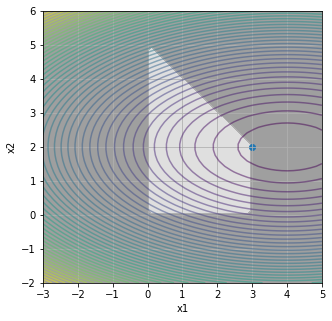

In [ ]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [ ]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [ ]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [ ]:
!pip install --upgrade --user cvxopt

  Using cached https://files.pythonhosted.org/packages/16/a0/0d090735e2639a74d6628831e02cc59284e3a3a4f5910f496fc6e435b645/cvxopt-1.2.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/39/537cb3e4e93f1ac5085dc3b3a43cfd99d0af9b29c44fcaa99490f526b611/mkl-2019.0-py2.py3-none-win_amd64.whl


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [ ]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [ ]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [ ]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [ ]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [ ]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701274e-06,
 'relative gap': 4.3942774404993765e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.1710307819972547e-16,
 'dual infeasibility': 1.9860273225978186e-16,
 'primal slack': 7.131816408857108e-07,
 'dual slack': 1.50695110360481e-08,
 'iterations': 8}

In [ ]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [ ]:
from sklearn.datasets import make_classification

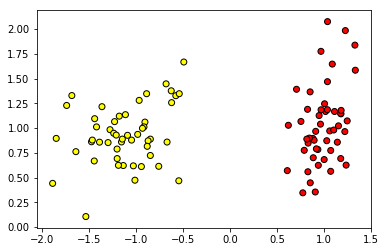

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

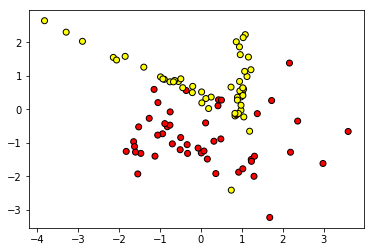

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

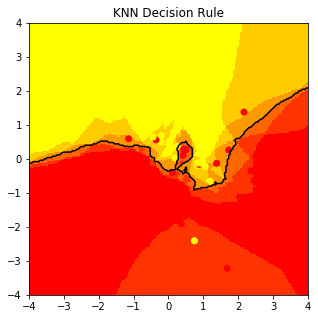

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [ ]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError()

    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()

    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel

    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError()

    def predict_proba(self, X):
        pass

    def predict(self, X):
        pass